In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [3]:
#introduce stopwords
stopwords = set(stopwords.words('english'))

In [4]:
#load and import the dataset
df = pd.read_csv('./IMDB Dataset.csv')

In [5]:
df.head(8)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
X = df['review']
y = df['sentiment']

In [8]:
#remove stopwords
X = X.apply(lambda review: [w for w in review.split() if w not in stopwords])

In [9]:
#convert to all lower case
X = X.apply(lambda review: [w.lower() for w in review])

In [10]:
#remove html tags
X = X.replace({'<.*?>': ''}, regex=True)

In [11]:
#remove non-alphabetical characters:
X = X.replace({'[^A-Za-z]': ''}, regex=True)

In [12]:
#change polarity labels into numbers:
y = y.replace('positive', 1)
y = y.replace('negative', 0)

In [13]:
X.head()

0    [one, reviewers, mentioned, watching, 1, oz, e...
1    [a, wonderful, little, production., <br, /><br...
2    [i, thought, wonderful, way, spend, time, hot,...
3    [basically, there's, family, little, boy, (jak...
4    [petter, mattei's, "love, time, money", visual...
Name: review, dtype: object

In [14]:
y.head()

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

In [15]:
#train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [16]:
#text tokenization
token = Tokenizer(lower=False)
token.fit_on_texts(X_train)

In [17]:
#transform texts to sequences
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

max_length = 300

X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [18]:
total_words = len(token.word_index) + 1

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
# Vectorizing positive reviews dataset
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos_p = vect.fit_transform(df[df.sentiment.isin(['positive'])].review)

In [21]:
#EDA
#Visualising the high frequency words for positive dataset
df_p = pd.DataFrame(vect_pos_p.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_p.nlargest(11, 'frequency')

,frequency
br,97954
film,42110
movie,37854
like,17714
good,15025
just,14109
great,12964
story,12934
time,12752
really,10739


In [22]:
# Vectorizing negative reviews dataset
vect_pos_n = vect.fit_transform(df[df.sentiment.isin(['negative'])].review)

In [23]:
#Visualising the high frequency words for negative dataset
df_n = pd.DataFrame(vect_pos_n.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_n.nlargest(11, 'frequency')

,frequency
br,103997
movie,50117
film,37595
like,22458
just,21075
good,14728
bad,14726
time,12358
really,12355
don,10622


In [24]:
#save the top frequency words in positive reviews into a new dataframe 
df_pf = df_p.nlargest(11, 'frequency')
df_pf = df_pf[1:]
print(df_pf)

        frequency
film        42110
movie       37854
like        17714
good        15025
just        14109
great       12964
story       12934
time        12752
really      10739
people       8719


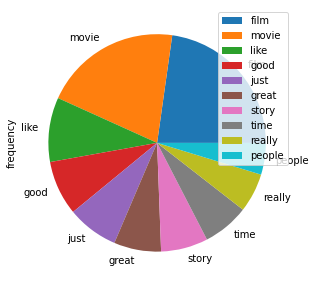

In [25]:
#generate a pie plot for the top words (positive reviews)
plot_p = df_pf.plot.pie(subplots=True, figsize=(5, 5))

In [26]:
#save the top frequency words in negative reviews into a new dataframe 
df_nf = df_n.nlargest(11, 'frequency')
df_nf = df_nf[1:]
print(df_nf)

        frequency
movie       50117
film        37595
like        22458
just        21075
good        14728
bad         14726
time        12358
really      12355
don         10622
story       10185


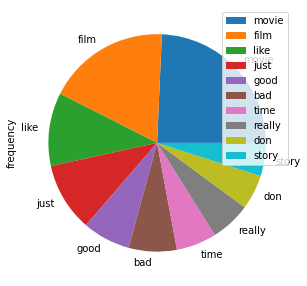

In [27]:
#generate a pie plot for the top words (negative reviews)
plot_n = df_nf.plot.pie(subplots=True, figsize=(5, 5))

In [28]:
#build a lstm model:
EMBED_DIM = 32
LSTM_OUT = 64

#build and add each layer:
lstm = Sequential()
lstm.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
lstm.add(LSTM(LSTM_OUT))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
#fit the training data into the lstm model
lstm.fit(X_train, y_train, batch_size = 128, epochs = 7)

Epoch 1/7
196/196 [==============================] - 45s 231ms/step - loss: 0.4522 - accuracy: 0.7811
Epoch 2/7
 43/196 [=====>........................] - ETA: 35s - loss: 0.1321 - accuracy: 0.9551

In [ ]:
#use lstm model to test
y_pred = lstm.predict_classes(X_test, batch_size=128)

In [ ]:
#model evaluation, getting the accuracy score
true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true +=1
        
print('LSTM Accuracy: {}'.format(true/len(y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
#Confusion matrix for RNN with LSTM
cm_rnn=confusion_matrix(y_test,y_pred)

In [ ]:
import scikitplot as skplt

In [ ]:
#plot the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test,y_pred,normalize=False,figsize=(12,8))
plt.show()

In [ ]:
#Classification report for performance metrics
cr_rnn=classification_report(y_test,y_pred)
print('The Classification report is::\n',cr_rnn)

In [ ]:
#Builidng a Logistic Regression Model
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
docs = np.array(['The sun is shining',
                'The weather is sweet',
                'The sun is shining, the weather is sweet, and one and one is two'])


In [ ]:
#tokenize the docs into a bag of words:
count = CountVectorizer()
bag = count.fit_transform(docs)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
#use tfidf to transform the text tokens into vectors
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [ ]:
print(tfidf.fit_transform(bag).toarray())

In [ ]:
#word stemming:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [ ]:
def tokenizer(text):
    return text.split()

In [ ]:
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#tfidf features
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer_porter, use_idf=True, norm='l2', smooth_idf=True)

In [ ]:
y = df.sentiment.values
X = tfidf.fit_transform(df.review)

In [ ]:
#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size=0.5)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
#fit a logistic regression model
clf = LogisticRegressionCV(cv=5,
                           scoring='accuracy',
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300).fit(X_train, y_train)

In [ ]:
#save the logistic regression model
import pickle

In [ ]:
saved_clf = open('saved_clf.sav','wb')
pickle.dump(clf,saved_clf)
saved_clf.close()

In [ ]:
filename = 'saved_clf.sav'
saved_clf = pickle.load(open(filename, 'rb'))

In [ ]:
#Logistic regression model accuracy
saved_clf.score(X_test, y_test)
print('Logistic Regression model score: ',saved_clf.score(X_test,y_test))

In [ ]:
#Random forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#build a random forest classifier
rf = RandomForestClassifier(n_estimators=64)

In [ ]:
#fit a random forest model
rf = rf.fit(X_train, y_train)

In [ ]:
rf_score = rf.score(X_train, y_train)

In [ ]:
#use random forest model to predict
rf_pred = rf.predict(X_test)

In [ ]:
#show the confusion matrix of random forest model
rf_cm = confusion_matrix(y_test, rf_pred)

skplt.metrics.plot_confusion_matrix(y_test, rf_pred, normalize=False, figsize=(12,8))

In [ ]:
#random forest model report
rf_cr = classification_report(y_test, rf_pred)
print('Random forest classification report is::\n', rf_cr)

In [ ]:
#SVM model

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#build a svm classifier
svm = SGDClassifier(max_iter=1000, random_state=42)

In [ ]:
#fit the random svm model
svm = svm.fit(X_train, y_train)

In [ ]:
#making predictions using svm
svm_pred = svm.predict(X_test)

In [ ]:
#evaluate svm
svm_score=accuracy_score(y_test, svm_pred)

In [ ]:
print("svm_score :", svm_score)

In [ ]:
#print svm model report
svm_report = classification_report(y_test, svm_pred)

In [ ]:
print(svm_report)

In [ ]:
#svm confusion matrix
svm_cm = confusion_matrix(y_test, svm_pred)
skplt.metrics.plot_confusion_matrix(y_test, svm_pred, normalize=False, figsize=(12,8))

In [ ]:
#NB model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#build NB classifer
nb = MultinomialNB()

In [ ]:
#fit NB model using train data
nb = nb.fit(X_train, y_train)

In [ ]:
#predict using NB model
nb_pred = nb.predict(X_test)
print(nb_pred)

In [ ]:
#accuracy
nb_score = accuracy_score(y_test, nb_pred)
print("nb_score :", nb_score)

In [ ]:
#Naive Bayes model report
nb_report = classification_report(y_test, nb_pred)
print(nb_report)

In [ ]:
#NB model matrix
nb_cm = confusion_matrix(y_test, nb_pred)
skplt.metrics.plot_confusion_matrix(y_test, nb_pred, normalize=False, figsize=(12,8))